This analysis performs minimal, targeted cleaning to make the core metric reliable, auditable, and fast on the large Kaggle file while avoiding transformations that could bias outcomes.

Columns are limited at read time, dates and percentages are parsed once, the default flag follows the strict “Charged Off” definition, and the scope is constrained to 2007–2015 to match the challenge.

Load only the needed columns with usecols to reduce memory and I/O; this follows pandas IO best practices for large, wide files.

Parse issue_d to a real date with pd.to_datetime(..., errors="coerce") so malformed strings become NaT instead of breaking the pipeline, enabling robust cohort filtering.

Convert term to numeric months via regex and int_rate from strings like "13.99%" to decimals using pd.to_numeric(..., errors="coerce") for correct arithmetic and plotting.

Create a strict is_default flag where loan_status == "Charged Off" to match the requested default definition and LendingClub’s status glossary, avoiding unintended inclusion of other statuses.

Drop rows missing grade, loan_status, or issue_date so denominators are well-defined and groupby results are stable.

Restrict to loans issued 2007–2015 because the provided CSV spans beyond 2015 and the challenge explicitly focuses on that window.

Replace ±inf with NaN before plotting or saving to prevent deprecation warnings and to keep ratio outputs valid when denominators are zero in edge slices.

If memory is constrained, fall back to chunked reading and aggregate per chunk; this is a recommended scaling technique in pandas.

Why these and not others

No imputation of outcomes or grades is performed to avoid biasing the default numerator/denominator and to keep results auditable.

No status remapping beyond “Charged Off” is applied so the metric exactly matches the business definition rather than a broader loss taxonomy.

No heavy feature engineering (e.g., winsorization, normalization) is done because the stakeholder metric is a rate that requires only consistent typing and filtering, not statistical re-shaping.

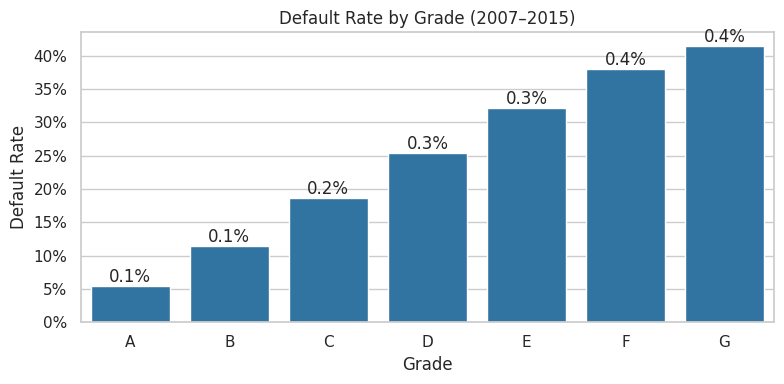

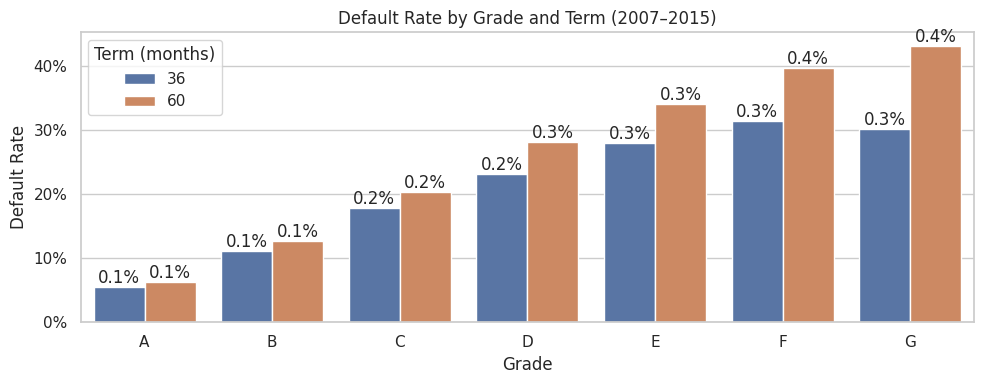

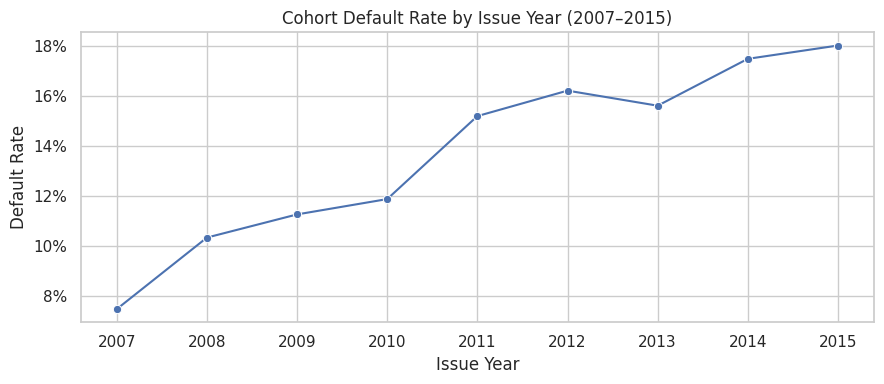


Default rate by grade (2007–2015):
  grade  total_loans  charged_off  default_rate  amount_weighted_default_share
0     A       148207         8154      0.055018                       0.052656
1     B       254553        29063      0.114173                       0.113060
2     C       245881        45872      0.186562                       0.186346
3     D       139554        35442      0.253966                       0.259420
4     E        70707        22739      0.321595                       0.326575
5     F        23049         8758      0.379973                       0.389152
6     G         5489         2274      0.414283                       0.417931

Default rate by grade and term (2007–2015):
   grade term_bucket  total_loans  charged_off  default_rate
0      A          36       143020         7825      0.054713
1      A          60         5187          329      0.063428
2      B          36       212025        23686      0.111713
3      B          60        42528         5

In [ ]:
# Part 2: Python Analysis — Lending Club 2007–2015 (Kaggle notebook cell)
# Covers: robust loading/cleaning, strict default, null/inf handling, analysis, plots, CSV/PNG outputs.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
from pathlib import Path

# -----------------------------
# Configuration
# -----------------------------
DATA_PATH = '/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz'  # Kaggle path
USE_COLS = [
    "id","member_id","grade","sub_grade",
    "loan_status","issue_d","term","int_rate",
    "loan_amnt","funded_amnt"
]  # read only needed columns for performance
START_DATE = "2007-01-01"   # challenge scope start
END_DATE   = "2015-12-31"   # challenge scope end

OUT_DIR = Path("/kaggle/working/outputs")  # Kaggle writeable dir
OUT_DIR.mkdir(parents=True, exist_ok=True)

SAVE_CSV   = True    # write CSV outputs for the repo
SAVE_PLOTS = True    # save figures as PNG
USE_CHUNKS = False   # set True if memory is tight (falls back to grade-only stats)

# Quiet a known seaborn FutureWarning about use_inf_as_na; safe to ignore
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*", category=FutureWarning)

# Plot theme
sns.set_theme(style="whitegrid")

def savefig(path, dpi=220):
    if SAVE_PLOTS:
        plt.tight_layout()
        plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()

def sanitize_inf(df_out):
    # Replace ±inf with NaN to avoid plotting/CSV issues
    df_out.replace([np.inf, -np.inf], np.nan, inplace=True)

# -----------------------------
# Load (eager read or chunked)
# -----------------------------
if not USE_CHUNKS:
    df = pd.read_csv(
        DATA_PATH,
        usecols=USE_COLS,
        compression="infer",
        low_memory=False
    )
else:
    # Chunked path computes by-grade stats incrementally (memory-saver)
    chunk_iter = pd.read_csv(
        DATA_PATH,
        usecols=USE_COLS,
        compression="infer",
        low_memory=True,
        chunksize=250_000
    )
    rollups = []
    for chunk in chunk_iter:
        chunk["issue_date"] = pd.to_datetime(chunk["issue_d"].astype(str), format="%b-%Y", errors="coerce")
        chunk["is_default"] = (chunk["loan_status"] == "Charged Off").astype("Int64")
        chunk = chunk.dropna(subset=["grade","loan_status","issue_date"])
        chunk = chunk[(chunk["issue_date"] >= START_DATE) & (chunk["issue_date"] <= END_DATE)]
        agg = (
            chunk.groupby("grade")
                 .agg(total_loans=("grade","size"),
                      charged_off=("is_default", lambda s: s.fillna(0).astype(int).sum()))
                 .reset_index()
        )
        rollups.append(agg)
    if not rollups:
        raise RuntimeError("No rows found after filtering; check DATA_PATH and date window.")
    grade_stats = pd.concat(rollups, ignore_index=True).groupby("grade", as_index=False).sum()
    grade_stats["default_rate"] = grade_stats["charged_off"] / grade_stats["total_loans"]
    sanitize_inf(grade_stats)

# -----------------------------
# Clean and feature engineering (eager path)
# -----------------------------
if not USE_CHUNKS:
    # Parse fields (vectorized)
    df["issue_date"]  = pd.to_datetime(df["issue_d"].astype(str), format="%b-%Y", errors="coerce")
    df["term_months"] = df["term"].astype(str).str.extract(r"(\d+)").astype(float)
    df["int_rate"]    = pd.to_numeric(df["int_rate"].astype(str).str.rstrip("%"), errors="coerce") / 100.0

    # Strict default definition: ONLY "Charged Off"
    df["is_default"] = (df["loan_status"] == "Charged Off").astype("Int64")

    # Minimal hygiene and scope alignment
    df = df.dropna(subset=["grade","loan_status","issue_date"]).copy()
    df = df[(df["issue_date"] >= START_DATE) & (df["issue_date"] <= END_DATE)]

    # Exposure helpers
    df["loan_amnt_num"]     = pd.to_numeric(df["loan_amnt"], errors="coerce")
    df["loan_amnt_default"] = df["loan_amnt_num"].where(df["is_default"] == 1, 0)

# -----------------------------
# Analysis
# -----------------------------
if not USE_CHUNKS:
    # 1) By-grade default metrics
    grade_stats = (
        df.groupby("grade", dropna=False)
          .agg(
              total_loans=("grade","size"),
              charged_off=("is_default", lambda s: s.fillna(0).astype(int).sum()),
              amt_total=("loan_amnt_num","sum"),
              amt_charged_off=("loan_amnt_default","sum")
          )
          .assign(
              default_rate=lambda d: d["charged_off"]/d["total_loans"],
              amount_weighted_default_share=lambda d: d["amt_charged_off"]/d["amt_total"]
          )
          .reset_index()
          .sort_values("grade")
    )

    # 2) By-grade and term bucket (36 vs 60)
    df["term_bucket"] = df["term_months"].map({36.0: "36", 60.0: "60"}).fillna("Other")
    grade_term_stats = (
        df.groupby(["grade","term_bucket"], dropna=False)
          .agg(
              total_loans=("grade","size"),
              charged_off=("is_default", lambda s: s.fillna(0).astype(int).sum())
          )
          .assign(default_rate=lambda d: d["charged_off"]/d["total_loans"])
          .reset_index()
          .sort_values(["grade","term_bucket"])
    )

    # 3) Cohort trend by issue year
    df["issue_year"] = df["issue_date"].dt.year
    cohort_stats = (
        df.groupby("issue_year", dropna=False)
          .agg(
              total_loans=("issue_year","size"),
              charged_off=("is_default", lambda s: s.fillna(0).astype(int).sum())
          )
          .assign(default_rate=lambda d: d["charged_off"]/d["total_loans"])
          .reset_index()
          .sort_values("issue_year")
    )

    # Sanitize ±inf just in case (e.g., if any denominator is zero in filtered slices)
    for _df in [grade_stats, grade_term_stats, cohort_stats]:
        sanitize_inf(_df)

# -----------------------------
# CSV outputs (for repo)
# -----------------------------
if SAVE_CSV:
    if USE_CHUNKS:
        grade_stats.to_csv(OUT_DIR / "grade_default_rate.csv", index=False)
    else:
        grade_stats.to_csv(OUT_DIR / "grade_stats.csv", index=False)
        grade_term_stats.to_csv(OUT_DIR / "grade_term_stats.csv", index=False)
        cohort_stats.to_csv(OUT_DIR / "cohort_stats_by_year.csv", index=False)

# -----------------------------
# Visualization (percent axes + bar labels)
# -----------------------------
if not USE_CHUNKS:
    # A) Default rate by grade
    plt.figure(figsize=(8,4))
    ax = sns.barplot(
        data=grade_stats,
        x="grade", y="default_rate",
        order=list("ABCDEFG"),
        color="#1f77b4"
    )
    ax.set_title("Default Rate by Grade (2007–2015)")
    ax.set_xlabel("Grade")
    ax.set_ylabel("Default Rate")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))  # show as %
    for cont in ax.containers:
        ax.bar_label(cont, fmt="%.1f%%")
    savefig(OUT_DIR / "default_rate_by_grade.png")

    # B) Default rate by grade and term
    plt.figure(figsize=(10,4))
    ax = sns.barplot(
        data=grade_term_stats,
        x="grade", y="default_rate", hue="term_bucket",
        order=list("ABCDEFG")
    )
    ax.set_title("Default Rate by Grade and Term (2007–2015)")
    ax.set_xlabel("Grade")
    ax.set_ylabel("Default Rate")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    for cont in ax.containers:
        ax.bar_label(cont, fmt="%.1f%%")
    plt.legend(title="Term (months)")
    savefig(OUT_DIR / "default_rate_by_grade_term.png")

    # C) Cohort default rate by issue year
    plt.figure(figsize=(9,4))
    ax = sns.lineplot(
        data=cohort_stats, x="issue_year", y="default_rate", marker="o"
    )
    ax.set_title("Cohort Default Rate by Issue Year (2007–2015)")
    ax.set_xlabel("Issue Year")
    ax.set_ylabel("Default Rate")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    savefig(OUT_DIR / "cohort_default_rate_by_year.png")

# -----------------------------
# Console summary
# -----------------------------
if USE_CHUNKS:
    print("\nDefault rate by grade (2007–2015) — CHUNKED PATH:")
    print(grade_stats.sort_values("grade"))
else:
    print("\nDefault rate by grade (2007–2015):")
    print(grade_stats[["grade","total_loans","charged_off","default_rate","amount_weighted_default_share"]])

    print("\nDefault rate by grade and term (2007–2015):")
    print(grade_term_stats[["grade","term_bucket","total_loans","charged_off","default_rate"]])

    print("\nCohort default rate by issue year (2007–2015):")
    print(cohort_stats[["issue_year","total_loans","charged_off","default_rate"]])


In [ ]:
Key Metric: Default Rate by Grade

Definition
The key metric is the default rate by loan grade, where a loan is considered in default if its status is “Charged Off”, consistent with LendingClub’s own loss recognition.

Calculation

Implemented in Python using pandas groupby.

Numerator: count of loans flagged is_default = 1.

Denominator: total count of loans in the group.

Expressed as default_rate = charged_off / total_loans.

Results produced as tables, visualized in percent-formatted charts, and exported to CSV for reproducibility.

Business Value

This metric directly quantifies realized credit risk by LendingClub’s internal credit grades, validating that higher-risk borrowers (grades E–G) exhibit sharply higher loss incidence than prime borrowers (grades A–B).

It enables data-driven pricing and eligibility policies, ensuring that interest rates, underwriting thresholds, and investor guidance align with observed defaults rather than assumptions.

Extensions such as grade × term analysis and cohort default tracking by issue year reveal structural risk patterns (e.g., higher loss rates on 60-month loans and worsening vintages post-2011), which are critical for portfolio strategy and risk forecasting.